In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-06-22 11:25:48.478780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 11:25:48.478809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 15:44:25.878018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 15:44:25.878050: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 15:44:25.878071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 15:44:25.878323: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 3s 11ms/step - loss: 0.7053 - accuracy: 0.5018 - auc: 0.5026 - val_loss: 0.6950 - val_accuracy: 0.5055 - val_auc: 0.5047
Epoch 2/119
130/130 [==============================] - 1s 5ms/step - loss: 0.7031 - accuracy: 0.5019 - auc: 0.5052 - val_loss: 0.6905 - val_accuracy: 0.5289 - val_auc: 0.5415
Epoch 3/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6989 - accuracy: 0.5114 - auc: 0.5196 - val_loss: 0.6867 - val_accuracy: 0.5512 - val_auc: 0.5756
Epoch 4/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6955 - accuracy: 0.5186 - auc: 0.5309 - val_loss: 0.6829 - val_accuracy: 0.5702 - val_auc: 0.6086
Epoch 5/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6902 - accuracy: 0.5340 - auc: 0.5512 - val_loss: 0.6793 - val_accuracy: 0.5881 - val_auc: 0.6365
Epoch 6/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6882 - accuracy: 0.5342 - auc: 0.5570 - val_loss: 0.6757 - 

Epoch 48/119
130/130 [==============================] - 1s 8ms/step - loss: 0.4766 - accuracy: 0.7827 - auc: 0.8617 - val_loss: 0.3904 - val_accuracy: 0.8652 - val_auc: 0.9300
Epoch 49/119
130/130 [==============================] - 1s 6ms/step - loss: 0.4723 - accuracy: 0.7857 - auc: 0.8643 - val_loss: 0.3858 - val_accuracy: 0.8679 - val_auc: 0.9316
Epoch 50/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4675 - accuracy: 0.7895 - auc: 0.8683 - val_loss: 0.3813 - val_accuracy: 0.8701 - val_auc: 0.9332
Epoch 51/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4680 - accuracy: 0.7884 - auc: 0.8678 - val_loss: 0.3773 - val_accuracy: 0.8731 - val_auc: 0.9344
Epoch 52/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4651 - accuracy: 0.7916 - auc: 0.8692 - val_loss: 0.3735 - val_accuracy: 0.8753 - val_auc: 0.9357
Epoch 53/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4561 - accuracy: 0.7969 - auc: 0.8761 - va

130/130 [==============================] - 1s 6ms/step - loss: 0.5440 - accuracy: 0.7326 - auc: 0.8089 - val_loss: 0.4681 - val_accuracy: 0.8297 - val_auc: 0.9085
Epoch 21/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5327 - accuracy: 0.7369 - auc: 0.8169 - val_loss: 0.4559 - val_accuracy: 0.8353 - val_auc: 0.9133
Epoch 22/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5257 - accuracy: 0.7422 - auc: 0.8217 - val_loss: 0.4448 - val_accuracy: 0.8416 - val_auc: 0.9173
Epoch 23/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5182 - accuracy: 0.7467 - auc: 0.8286 - val_loss: 0.4345 - val_accuracy: 0.8471 - val_auc: 0.9208
Epoch 24/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5116 - accuracy: 0.7553 - auc: 0.8343 - val_loss: 0.4253 - val_accuracy: 0.8518 - val_auc: 0.9238
Epoch 25/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5028 - accuracy: 0.7625 - auc: 0.8411 - val_loss: 0.416

130/130 [==============================] - 1s 5ms/step - loss: 0.3561 - accuracy: 0.8637 - auc: 0.9271 - val_loss: 0.2863 - val_accuracy: 0.9172 - val_auc: 0.9547
Epoch 113/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3568 - accuracy: 0.8671 - auc: 0.9270 - val_loss: 0.2856 - val_accuracy: 0.9172 - val_auc: 0.9549
Epoch 114/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3562 - accuracy: 0.8685 - auc: 0.9280 - val_loss: 0.2850 - val_accuracy: 0.9176 - val_auc: 0.9550
Epoch 115/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3525 - accuracy: 0.8672 - auc: 0.9284 - val_loss: 0.2841 - val_accuracy: 0.9178 - val_auc: 0.9552
Epoch 116/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3536 - accuracy: 0.8681 - auc: 0.9284 - val_loss: 0.2835 - val_accuracy: 0.9178 - val_auc: 0.9553
Epoch 117/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3504 - accuracy: 0.8675 - auc: 0.9296 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.3455 - accuracy: 0.8741 - auc: 0.9315 - val_loss: 0.2813 - val_accuracy: 0.9179 - val_auc: 0.9553
Epoch 85/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3413 - accuracy: 0.8744 - auc: 0.9329 - val_loss: 0.2807 - val_accuracy: 0.9178 - val_auc: 0.9554
Epoch 86/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3432 - accuracy: 0.8728 - auc: 0.9321 - val_loss: 0.2799 - val_accuracy: 0.9182 - val_auc: 0.9556
Epoch 87/119
130/130 [==============================] - 1s 4ms/step - loss: 0.3433 - accuracy: 0.8738 - auc: 0.9327 - val_loss: 0.2793 - val_accuracy: 0.9183 - val_auc: 0.9557
Epoch 88/119
130/130 [==============================] - 0s 4ms/step - loss: 0.3382 - accuracy: 0.8773 - auc: 0.9343 - val_loss: 0.2786 - val_accuracy: 0.9182 - val_auc: 0.9558
Epoch 89/119
130/130 [==============================] - 0s 4ms/step - loss: 0.3380 - accuracy: 0.8767 - auc: 0.9343 - val_loss: 0.277

130/130 [==============================] - 1s 4ms/step - loss: 0.5909 - accuracy: 0.6858 - auc: 0.7573 - val_loss: 0.5294 - val_accuracy: 0.8183 - val_auc: 0.8975
Epoch 57/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5837 - accuracy: 0.6953 - auc: 0.7680 - val_loss: 0.5214 - val_accuracy: 0.8236 - val_auc: 0.9017
Epoch 58/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5768 - accuracy: 0.7006 - auc: 0.7743 - val_loss: 0.5131 - val_accuracy: 0.8296 - val_auc: 0.9057
Epoch 59/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5739 - accuracy: 0.7039 - auc: 0.7774 - val_loss: 0.5051 - val_accuracy: 0.8349 - val_auc: 0.9094
Epoch 60/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5646 - accuracy: 0.7126 - auc: 0.7887 - val_loss: 0.4966 - val_accuracy: 0.8411 - val_auc: 0.9128
Epoch 61/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5619 - accuracy: 0.7136 - auc: 0.7899 - val_loss: 0.488

130/130 [==============================] - 1s 4ms/step - loss: 0.3773 - accuracy: 0.8551 - auc: 0.9185 - val_loss: 0.2959 - val_accuracy: 0.9143 - val_auc: 0.9527
Epoch 149/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3775 - accuracy: 0.8553 - auc: 0.9177 - val_loss: 0.2954 - val_accuracy: 0.9150 - val_auc: 0.9527
Epoch 150/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3805 - accuracy: 0.8538 - auc: 0.9170 - val_loss: 0.2952 - val_accuracy: 0.9146 - val_auc: 0.9528
Epoch 151/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3789 - accuracy: 0.8537 - auc: 0.9171 - val_loss: 0.2948 - val_accuracy: 0.9144 - val_auc: 0.9528
Epoch 152/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3801 - accuracy: 0.8538 - auc: 0.9165 - val_loss: 0.2946 - val_accuracy: 0.9144 - val_auc: 0.9529
Epoch 153/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3749 - accuracy: 0.8550 - auc: 0.9188 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3293 - accuracy: 0.8767 - auc: 0.9366 - val_loss: 0.2653 - val_accuracy: 0.9204 - val_auc: 0.9589
Epoch 241/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3261 - accuracy: 0.8802 - auc: 0.9378 - val_loss: 0.2650 - val_accuracy: 0.9205 - val_auc: 0.9590
Epoch 242/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3255 - accuracy: 0.8778 - auc: 0.9380 - val_loss: 0.2647 - val_accuracy: 0.9208 - val_auc: 0.9591
Epoch 243/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3280 - accuracy: 0.8765 - auc: 0.9367 - val_loss: 0.2646 - val_accuracy: 0.9205 - val_auc: 0.9591
Epoch 244/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3247 - accuracy: 0.8802 - auc: 0.9379 - val_loss: 0.2642 - val_accuracy: 0.9206 - val_auc: 0.9591
Epoch 245/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3302 - accuracy: 0.8776 - auc: 0.9366 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.4147 - accuracy: 0.8326 - auc: 0.9009 - val_loss: 0.3187 - val_accuracy: 0.9094 - val_auc: 0.9495
Epoch 83/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4141 - accuracy: 0.8344 - auc: 0.9012 - val_loss: 0.3179 - val_accuracy: 0.9102 - val_auc: 0.9496
Epoch 84/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4083 - accuracy: 0.8380 - auc: 0.9045 - val_loss: 0.3170 - val_accuracy: 0.9103 - val_auc: 0.9496
Epoch 85/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4108 - accuracy: 0.8387 - auc: 0.9032 - val_loss: 0.3163 - val_accuracy: 0.9103 - val_auc: 0.9496
Epoch 86/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4093 - accuracy: 0.8354 - auc: 0.9034 - val_loss: 0.3156 - val_accuracy: 0.9107 - val_auc: 0.9497
Epoch 87/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4054 - accuracy: 0.8393 - auc: 0.9051 - val_loss: 0.314

130/130 [==============================] - 1s 5ms/step - loss: 0.3409 - accuracy: 0.8712 - auc: 0.9319 - val_loss: 0.2737 - val_accuracy: 0.9200 - val_auc: 0.9571
Epoch 175/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3441 - accuracy: 0.8715 - auc: 0.9308 - val_loss: 0.2735 - val_accuracy: 0.9197 - val_auc: 0.9573
Epoch 176/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3425 - accuracy: 0.8706 - auc: 0.9311 - val_loss: 0.2732 - val_accuracy: 0.9197 - val_auc: 0.9573
Epoch 177/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3399 - accuracy: 0.8733 - auc: 0.9324 - val_loss: 0.2729 - val_accuracy: 0.9191 - val_auc: 0.9574
Epoch 178/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3409 - accuracy: 0.8703 - auc: 0.9317 - val_loss: 0.2726 - val_accuracy: 0.9197 - val_auc: 0.9575
Epoch 179/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3452 - accuracy: 0.8696 - auc: 0.9297 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.6556 - accuracy: 0.6098 - auc: 0.6577 - val_loss: 0.6363 - val_accuracy: 0.6970 - val_auc: 0.7773
Epoch 17/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6128 - auc: 0.6609 - val_loss: 0.6302 - val_accuracy: 0.7049 - val_auc: 0.7887
Epoch 18/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6216 - auc: 0.6752 - val_loss: 0.6232 - val_accuracy: 0.7150 - val_auc: 0.7996
Epoch 19/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6346 - auc: 0.6887 - val_loss: 0.6153 - val_accuracy: 0.7269 - val_auc: 0.8104
Epoch 20/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6364 - accuracy: 0.6376 - auc: 0.6948 - val_loss: 0.6070 - val_accuracy: 0.7370 - val_auc: 0.8208
Epoch 21/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6309 - accuracy: 0.6482 - auc: 0.7040 - val_loss: 0.598

130/130 [==============================] - 1s 4ms/step - loss: 0.3576 - accuracy: 0.8677 - auc: 0.9260 - val_loss: 0.2876 - val_accuracy: 0.9184 - val_auc: 0.9540
Epoch 109/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3601 - accuracy: 0.8657 - auc: 0.9253 - val_loss: 0.2872 - val_accuracy: 0.9187 - val_auc: 0.9541
Epoch 110/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3564 - accuracy: 0.8683 - auc: 0.9264 - val_loss: 0.2867 - val_accuracy: 0.9183 - val_auc: 0.9542
Epoch 111/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3544 - accuracy: 0.8675 - auc: 0.9276 - val_loss: 0.2859 - val_accuracy: 0.9191 - val_auc: 0.9543
Epoch 112/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3567 - accuracy: 0.8680 - auc: 0.9265 - val_loss: 0.2856 - val_accuracy: 0.9187 - val_auc: 0.9544
Epoch 113/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3542 - accuracy: 0.8677 - auc: 0.9274 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3116 - accuracy: 0.8825 - auc: 0.9423 - val_loss: 0.2570 - val_accuracy: 0.9233 - val_auc: 0.9621
Epoch 201/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3121 - accuracy: 0.8829 - auc: 0.9423 - val_loss: 0.2570 - val_accuracy: 0.9229 - val_auc: 0.9621
Epoch 202/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3080 - accuracy: 0.8861 - auc: 0.9436 - val_loss: 0.2566 - val_accuracy: 0.9229 - val_auc: 0.9621
Epoch 203/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3093 - accuracy: 0.8837 - auc: 0.9434 - val_loss: 0.2564 - val_accuracy: 0.9226 - val_auc: 0.9622
Epoch 204/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3094 - accuracy: 0.8842 - auc: 0.9434 - val_loss: 0.2562 - val_accuracy: 0.9228 - val_auc: 0.9622
Epoch 205/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3069 - accuracy: 0.8838 - auc: 0.9439 - val_loss: 

4160/4160 [==============================] - 16s 4ms/step - loss: 0.4214 - accuracy: 0.8817 - auc: 0.9317 - val_loss: 0.3480 - val_accuracy: 0.8994 - val_auc: 0.9480
Epoch 6/6
4160/4160 [==============================] - 14s 3ms/step - loss: 0.4273 - accuracy: 0.8803 - auc: 0.9308 - val_loss: 0.3314 - val_accuracy: 0.9041 - val_auc: 0.9495
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.3086574077606201, 'epoch': 3}, 'best_auc': {'auc': 0.9544333219528198, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9102500081062317, 'epoch': 4}}
Epoch 1/6
4160/4160 [==============================] - 16s 4ms/step - loss: 0.3786 - accuracy: 0.8430 - auc: 0.9160 - val_loss: 0.2788 - val_accuracy: 0.8982 - val_auc: 0.9544
Epoch 2/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.3045 - accuracy: 0.8839 - auc: 0.9430 - val_loss: 0.2545 - val_accuracy: 0.9071 - val_auc: 0.9601
Epoch 3/6
4160/4160 [==============================] - 17s 4ms

4160/4160 [==============================] - 16s 4ms/step - loss: 0.2878 - accuracy: 0.9010 - auc: 0.9491 - val_loss: 0.2364 - val_accuracy: 0.9183 - val_auc: 0.9635
Epoch 12/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.2874 - accuracy: 0.9035 - auc: 0.9497 - val_loss: 0.2418 - val_accuracy: 0.9207 - val_auc: 0.9644
Epoch 13/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.2879 - accuracy: 0.9036 - auc: 0.9486 - val_loss: 0.2368 - val_accuracy: 0.9155 - val_auc: 0.9640
Epoch 14/18
4160/4160 [==============================] - 13s 3ms/step - loss: 0.2864 - accuracy: 0.9028 - auc: 0.9503 - val_loss: 0.2368 - val_accuracy: 0.9168 - val_auc: 0.9655
Epoch 15/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.2872 - accuracy: 0.9004 - auc: 0.9498 - val_loss: 0.2417 - val_accuracy: 0.9179 - val_auc: 0.9605
Epoch 16/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.2836 - accuracy: 0.9026 - auc: 0.9509 - va

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.4070 - accuracy: 0.8208 - auc: 0.9021 - val_loss: 0.2592 - val_accuracy: 0.9127 - val_auc: 0.9596
Epoch 2/6
4160/4160 [==============================] - 14s 3ms/step - loss: 0.2759 - accuracy: 0.9004 - auc: 0.9522 - val_loss: 0.2263 - val_accuracy: 0.9216 - val_auc: 0.9665
Epoch 3/6
4160/4160 [==============================] - 14s 3ms/step - loss: 0.2532 - accuracy: 0.9110 - auc: 0.9578 - val_loss: 0.2220 - val_accuracy: 0.9230 - val_auc: 0.9676
Epoch 4/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.2460 - accuracy: 0.9140 - auc: 0.9596 - val_loss: 0.2195 - val_accuracy: 0.9260 - val_auc: 0.9676
Epoch 5/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.2409 - accuracy: 0.9164 - auc: 0.9609 - val_loss: 0.2223 - val_accuracy: 0.9219 - val_auc: 0.9673
Epoch 6/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.2409 - accuracy: 0.9177 - auc: 0.9607 - va

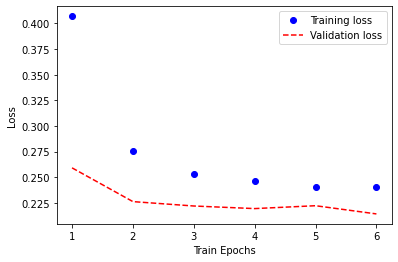

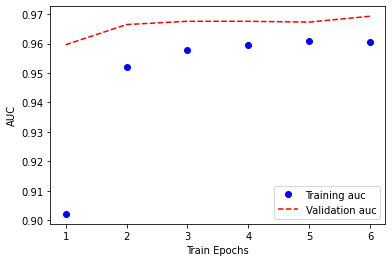

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

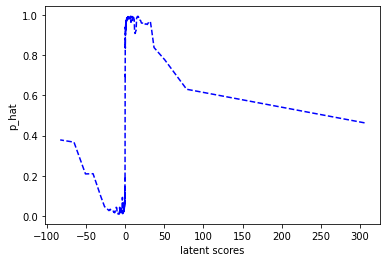

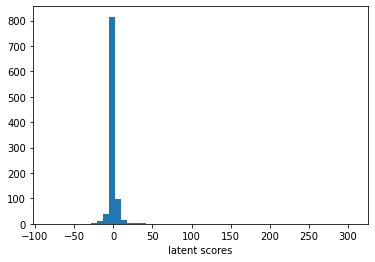

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

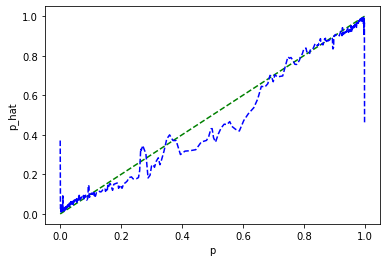

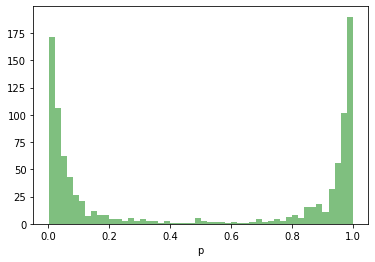

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

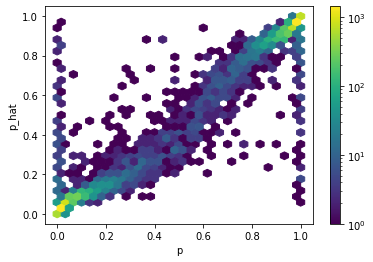

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

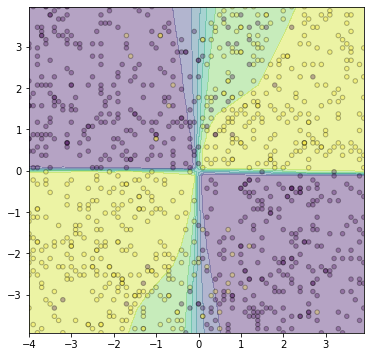

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.21947233378887177, 'epoch': 6},
 'best_auc': {'auc': 0.9679520130157471, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.9244999885559082, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7f3da9502970>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2979053854942322, 'epoch': 119},
  'best_auc': {'auc': 0.9521666169166565, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9150500297546387, 'epoch': 117}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.28166744112968445, 'epoch': 119},
  'best_auc': {'auc': 0.9556806087493896, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9185000061988831, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25951793789863586, 'epoch': 119},
  'best_auc': {'auc': 0.9593939781188965, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9225500226020813, 'epoch': 118}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.2630563974380493, 'epoch': 249},
  'best_auc': {'auc': 0.9593909382820129, 'epoch': 249},
  '

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25